Linking to GEOS 3.7.0, GDAL 2.4.0, PROJ 5.2.0
Skipping install of 'nhdplusTools' from a github remote, the SHA1 (e434f300) has not changed since last install.
  Use `force = TRUE` to force installation
USGS Support Package: https://owi.usgs.gov/R/packages.html#support


source,sourceName,features
<chr>,<chr>,<chr>
comid,NHDPlus comid,https://cida.usgs.gov/nldi/comid
huc12pp,HUC12 Pour Points,https://cida.usgs.gov/nldi/huc12pp
npdes_rad,EPA Office of Water (OW): Facilities that Discharge to Water NHDPlus Indexed Dataset,https://cida.usgs.gov/nldi/npdes_rad
nwissite,NWIS Sites,https://cida.usgs.gov/nldi/nwissite
wqp,Water Quality Portal,https://cida.usgs.gov/nldi/wqp


All intersections performed in latitude/longitude.
Reading NHDFlowline_Network
Writing NHDFlowline_Network
Reading CatchmentSP
Writing CatchmentSP


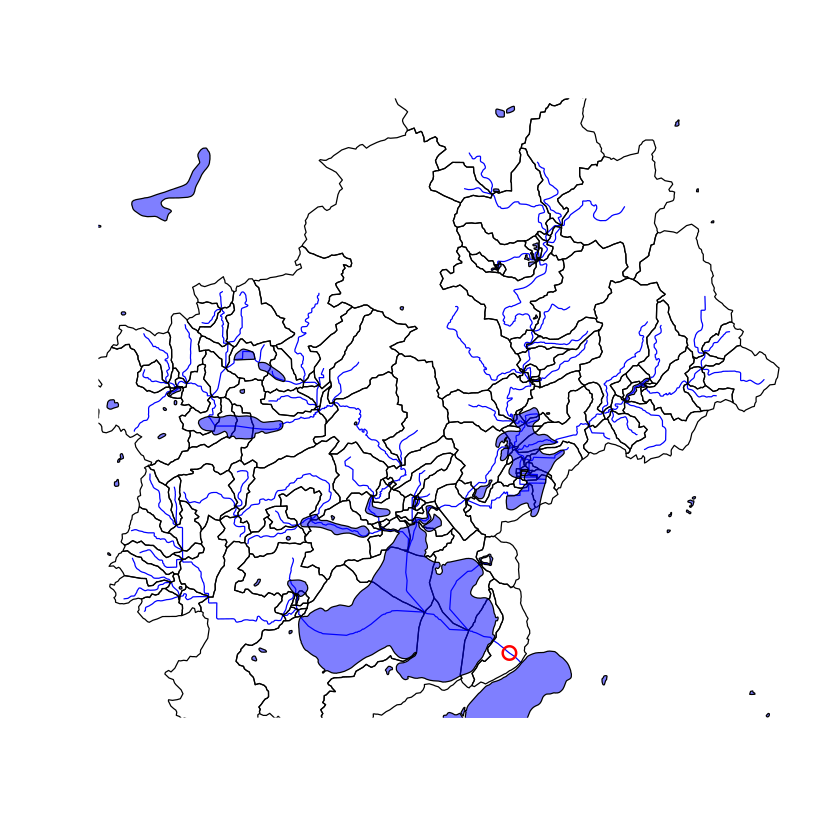

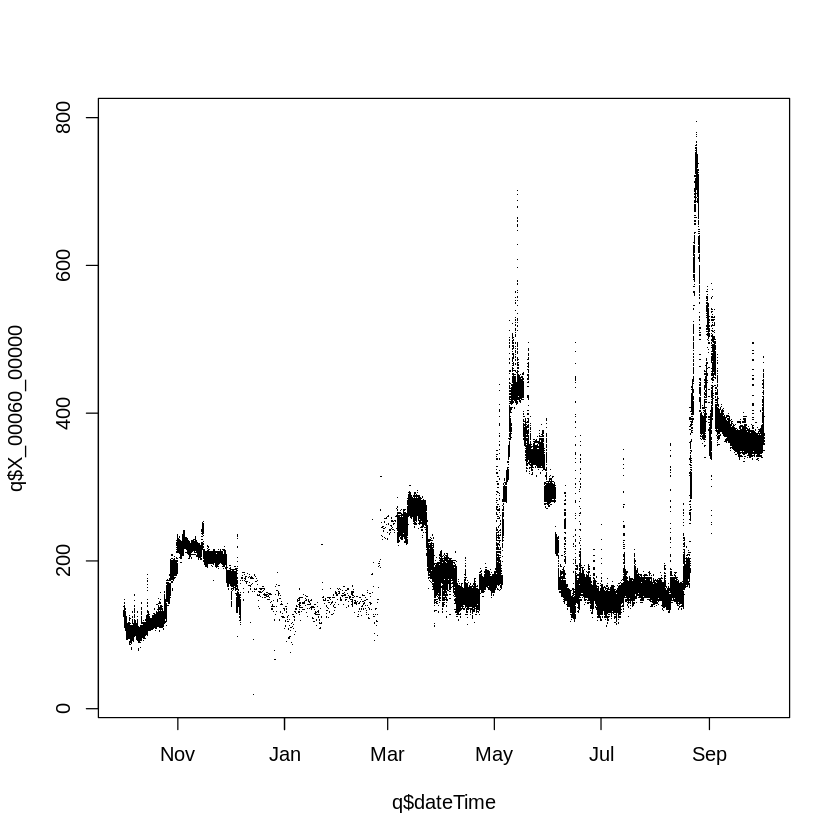

In [1]:
library(sf)
library(dataRetrieval)
library(nhdplusTools)

# Find a gage id here: https://maps.waterdata.usgs.gov/mapper/index.html

site <- "05428500"

site_meta <- dataRetrieval::readNWISsite(site)

site_meta <- st_as_sf(site_meta, coords = c("dec_long_va", "dec_lat_va"), crs = 4326)

nhdplusTools::discover_nldi_sources()

nldi_feature <- list(featureSource = "nwissite", 
                     featureID = paste0("USGS-", site))

flowline <- navigate_nldi(nldi_feature, 
                          mode = "upstreamTributaries", 
                          data_source = "")

subset_gpkg <-subset_nhdplus(comids = flowline$nhdplus_comid,
                             output_file = tempfile(fileext = ".gpkg"),
                             nhdplus_data = "download")

flowline <- sf::read_sf(subset_gpkg, "NHDFlowline_Network")
catchment <- sf::read_sf(subset_gpkg, "CatchmentSP")
waterbody <- sf::read_sf(subset_gpkg, "NHDWaterbody")

plot(sf::st_geometry(flowline), col = "blue")
plot(st_geometry(site_meta), cex = 1.5, lwd = 2, col = "red", add = TRUE)
plot(sf::st_geometry(catchment), add = TRUE)
plot(sf::st_geometry(waterbody), col = rgb(0, 0, 1, alpha = 0.5), add = TRUE)

# For more see: https://usgs-r.github.io/nhdplusTools/articles/nhdplusTools.html

discharge <- "00060"
start <- "2017-10-01"
end <- "2018-10-01"

q <- readNWISuv(site, discharge, start, end)

plot(q$dateTime, q$X_00060_00000, pch = ".")
